##Analyze and visualize sentiment patterns in social media data to understand public opinion and attitudes towards specific topics or brands

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import nltk
nltk.download('punkt')

from nltk.sentiment.vader import SentimentIntensityAnalyzer
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
import re

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
# create column names
col_names = ['ID', 'Entity', 'Sentiment', 'Content']
# Load the data
df = pd.read_csv(r"/content/twitter_training.csv", names=col_names)
df


,ID,Entity,Sentiment,Content
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
...,...,...,...,...
23999,4513,Google,Neutral,"A truly incredible game. Gaming is the ""show o..."
24000,4514,Google,Neutral,“Android Becomes Basically Unusable If You Tur...
24001,4514,Google,Neutral,"""Android basically becomes useless if you turn..."
24002,4514,Google,Neutral,"""Android Becomes the Unusable If You Turn Off ..."


In [ ]:
# basic information about the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24004 entries, 0 to 24003
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ID         24004 non-null  int64 
 1   Entity     24004 non-null  object
 2   Sentiment  24004 non-null  object
 3   Content    23784 non-null  object
dtypes: int64(1), object(3)
memory usage: 750.2+ KB


In [ ]:
# Check Data Dimensions
df.shape

(24004, 4)

In [ ]:
# check for missing values
df.isnull().sum()

ID             0
Entity         0
Sentiment      0
Content      220
dtype: int64

In [ ]:
# dropping the rows with content missing values
df.dropna(subset = ['Content'],inplace=True)

In [ ]:
# Count the total number of duplicate rows
total_duplicates = df[df.duplicated(keep='first')].shape[0]

print("Total duplicate rows:", total_duplicates)

Total duplicate rows: 835


In [ ]:
# Drop duplicate rows
df.drop_duplicates(keep='first', inplace=True)

# Reset the index after dropping duplicates
df.reset_index(drop=True, inplace=True)

In [ ]:
# replace irrelevant to neutral
df['Sentiment'] = df['Sentiment'].replace('Irrelevant', 'Neutral')

##Exploratory Data Analysis

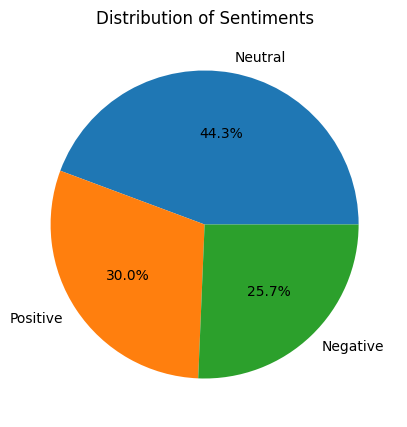

In [ ]:
# Calculate the distribution of sentiments
sentiment_distribution = df['Sentiment'].value_counts()

# Create a pie chart
plt.figure(figsize=(5, 5))
plt.pie(sentiment_distribution, labels=sentiment_distribution.index, autopct='%1.1f%%')
plt.title('Distribution of Sentiments')
plt.show()

The sentiment distribution is relatively balanced, with neutral sentiments being the most common. This analysis can guide actions such as engaging with neutral sentiments, addressing negative sentiments, and leveraging positive sentiments for marketing and brand promotion.

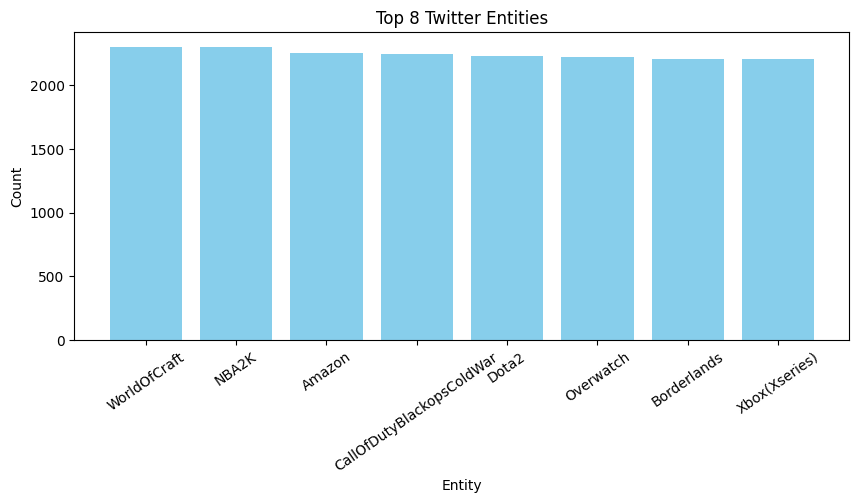

In [ ]:
# Calculate the distribution of entities
entity_distribution = df['Entity'].value_counts()
# Select the top 8 entities
top_8_entities = entity_distribution.head(8)
# Create a bar chart for the top 10 entities
plt.figure(figsize=(10, 4))
plt.bar(top_8_entities.index, top_8_entities.values, color='skyblue')
plt.title('Top 8 Twitter Entities')
plt.xlabel('Entity')
plt.ylabel('Count')
plt.xticks(rotation=35)
plt.show()

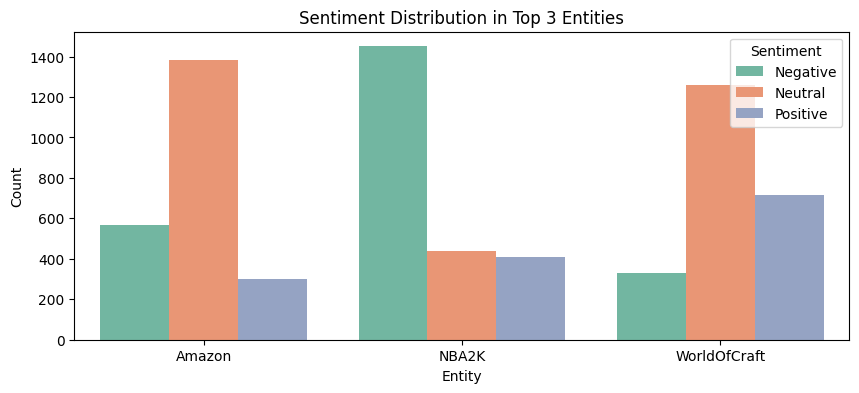

In [ ]:
# Calculate the distribution of entities
entity_distribution = df['Entity'].value_counts()
top_3_entities = entity_distribution.head(3).index

# Filter the DataFrame to include only the top 3 entities
df_top_3 = df[df['Entity'].isin(top_3_entities)]
# Create a grouped bar chart for sentiment distribution
plt.figure(figsize=(10, 4))
sns.countplot(data=df_top_3, x='Entity', hue='Sentiment', palette='Set2')
plt.title('Sentiment Distribution in Top 3 Entities')
plt.xlabel('Entity')
plt.ylabel('Count')
plt.show()

MaddenNFL and TomClancyRainbowSix: Given the negative sentiment in these entities, consider addressing issues or concerns raised by users, improving customer experience, and actively engaging with the community to resolve complaints and improve brand perception.

Verizon: Leverage the neutral sentiment by maintaining a consistent brand image and engaging with users to gather feedback and identify areas for improvement. Consider using the neutral sentiment as an opportunity to promote positive aspects of the brand. These recommendations can help tailor strategies for each entity based on sentiment trends and user feedback.

##Text Analysis with NLP Preprocessing

In [ ]:
# Load NLTK stopwords
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

stop_words = set(stopwords.words('english'))

# Initialize the WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [ ]:
#Function to preprocess text with lemmatization and stopwords removal
def preprocess_text(text):
    # Remove special characters, numbers, and links
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = text.lower()  # Convert to lowercase
    tokens = nltk.word_tokenize(text)
    tokens = [lemmatizer.lemmatize(word) for word in tokens]  # Lemmatize words
    tokens = [word for word in tokens if word not in stop_words]  # Remove stopwords
    return ' '.join(tokens)

# Apply preprocessing with lemmatization and stopwords removal to the 'Content' column
df['Cleaned_Content'] = df['Content'].apply(preprocess_text)

##Sentiment Analysis

In [ ]:
nltk.download('vader_lexicon')

# Initialize the sentiment analyzer without specifying the lexicon file
sia = SentimentIntensityAnalyzer()

# Function to get sentiment scores
def get_sentiment_scores(text):
    sentiment = sia.polarity_scores(text)
    return sentiment['compound']


df['Sentiment_Score'] = df['Cleaned_Content'].apply(get_sentiment_scores)

# Categorize sentiment based on the compound score
def categorize_sentiment(score):
    if score >= 0.05:
        return 'Positive'
    elif score <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

df['Sentiment_Predicted'] = df['Sentiment_Score'].apply(categorize_sentiment)

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


##Distribution of predicted sentiments

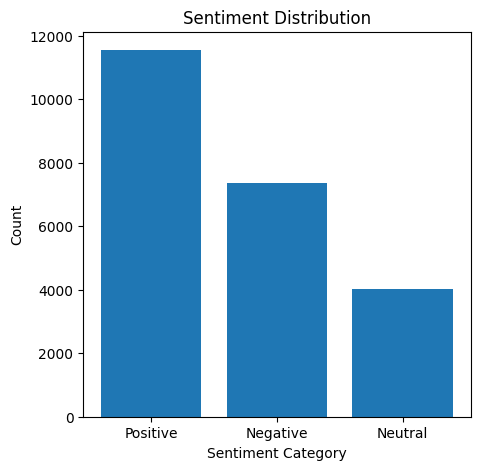

In [ ]:
# Calculate the distribution of predicted sentiments
sentiment_distribution = df['Sentiment_Predicted'].value_counts()

plt.figure(figsize=(5, 5))
plt.bar(sentiment_distribution.index, sentiment_distribution.values)
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment Category')
plt.ylabel('Count')
plt.show()

Sentiment Categories: The bar chart illustrates the distribution of predicted sentiments within the social media content. Sentiments are categorized into three main categories: Positive, Negative, and Neutral.

Positive Sentiment Prevalence: The most prevalent sentiment category is "Positive," indicating that a significant portion of the social media content expresses positive opinions or emotions. This suggests that users are actively sharing positive experiences, feedback, or sentiments related to various topics or entities.

User Engagement: The distribution of sentiment categories reflects the diverse range of opinions and emotions expressed by users on social media platforms. Organizations should consider engaging with users across all sentiment categories to respond to feedback, address concerns, and build positive relationships.

Monitoring Sentiment Trends: Regularly monitoring sentiment distribution can help organizations stay attuned to changes in public sentiment and adjust their strategies accordingly. An increase in negative sentiment, for example, may signal a need for issue resolution or improved communication.

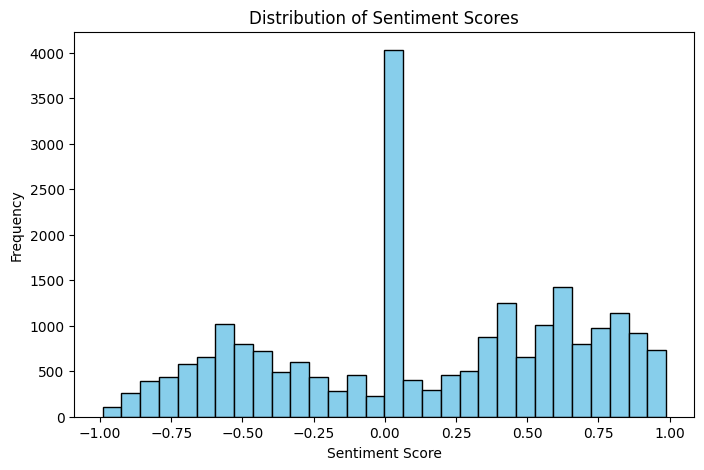

In [ ]:
# Create a histogram of sentiment scores
plt.figure(figsize=(8, 5))
plt.hist(df['Sentiment_Score'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Sentiment Scores')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.show()

Positive Sentiment Peak: A peak on the right side of the histogram corresponds to sentiment scores greater than 0, indicating positive sentiments. This suggests that a significant portion of the text data expresses positive sentiments.

Negative Sentiment Peak: Another peak on the left side of the histogram represents sentiment scores less than 0, signifying negative sentiments. This indicates the presence of text data expressing negative sentiments.

Neutral Sentiment: The central area of the histogram, around the score of 0, corresponds to neutral sentiments. It shows that a considerable volume of text data is neutral in nature.

##Text Length Analysis

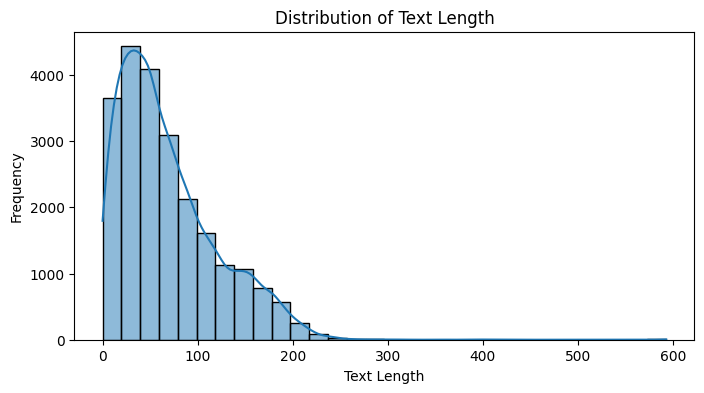

In [ ]:
# for text length analysis
df['Text_Length'] = df['Cleaned_Content'].str.len()  # Calculate text length
plt.figure(figsize=(8, 4))
sns.histplot(df['Text_Length'], bins=30, kde=True)
plt.title("Distribution of Text Length")
plt.xlabel("Text Length")
plt.ylabel("Frequency")
plt.show()

Peak at Short Texts: The histogram shows that there is a peak in the frequency of short texts. Many tweets are relatively brief in terms of character count. Longer Texts Exist: While short texts are prevalent, there is still a range of longer texts present in the dataset, as evidenced by the right tail of the distribution.



##Word Frequency Analysis

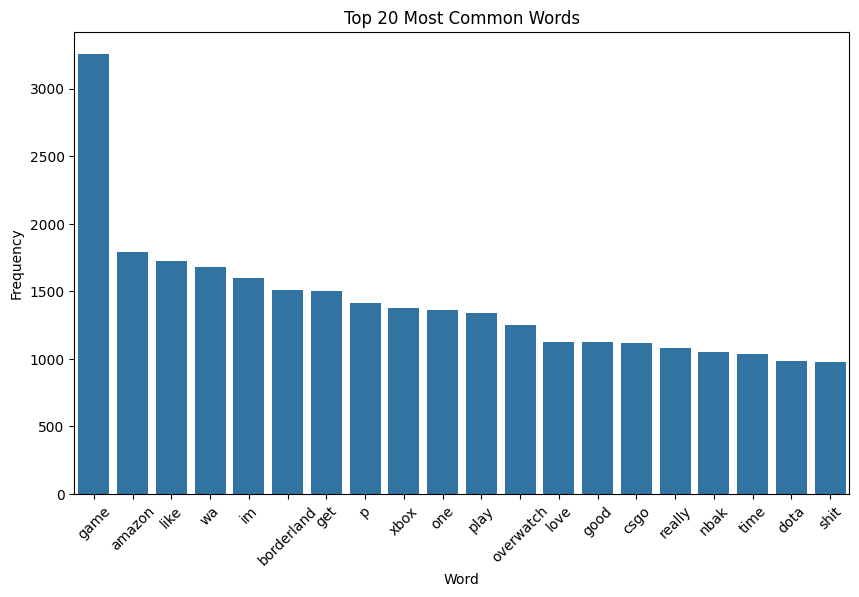

In [ ]:
# word frequency analysis
from collections import Counter
words = ' '.join(df['Cleaned_Content']).split()
word_counts = Counter(words)
most_common_words = word_counts.most_common(20)

# Plot the top N most common words
plt.figure(figsize=(10, 6))
sns.barplot(x=[word[0] for word in most_common_words], y=[word[1] for word in most_common_words])
plt.title("Top 20 Most Common Words")
plt.xlabel("Word")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.show()

Relevant Keywords: The most common words now primarily consist of relevant keywords specific to the content since stopwords was removed. Th most frequent word is Game. These words are likely to carry meaningful information about the topics or sentiments discussed.

Text Characteristics: The analysis provides insights into the characteristics of the text data after preprocessing, highlighting frequently occurring terms that are likely to be informative.

##Word Cloud of Lemmatized Social Media Content

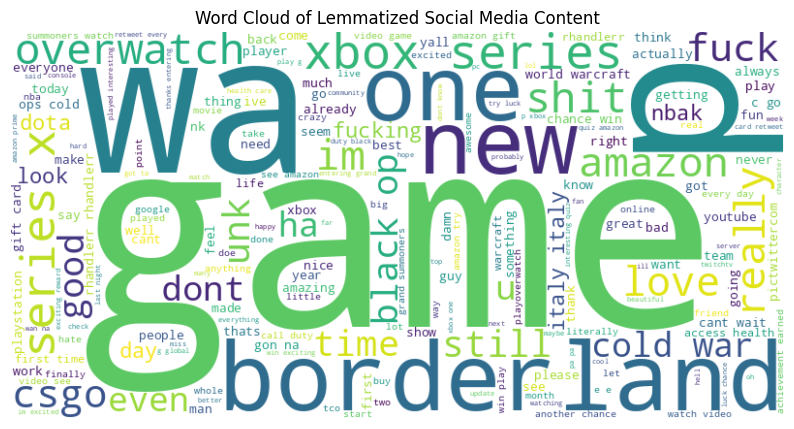

In [ ]:
# Join the lemmatized content into a single string
text_data_lemmatized = ' '.join(df['Cleaned_Content'].dropna())
# Generate a word cloud visualization
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_data_lemmatized)
# plot
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud of Lemmatized Social Media Content")
plt.show()

##Word Cloud for Positive Sentiment

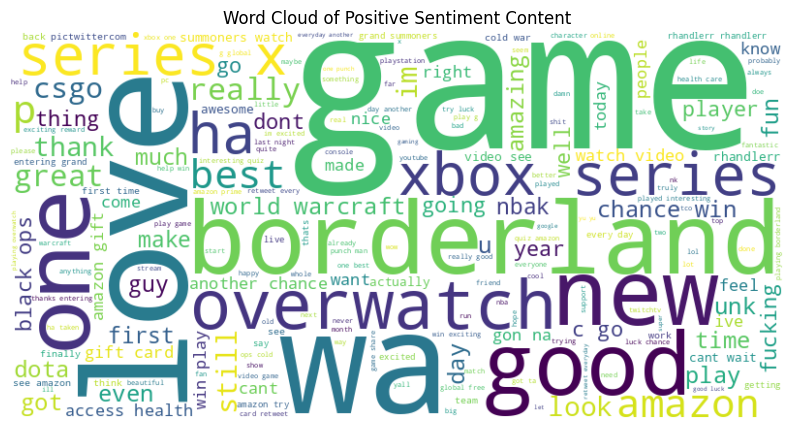

In [ ]:
# Filter data for positive sentiment
positive_data = df[df['Sentiment_Predicted'] == 'Positive']
# Combine all lemmatized text for positive sentiment
positive_text_data = ' '.join(positive_data['Cleaned_Content'].dropna())
# Generate a word cloud for positive sentiment
positive_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(positive_text_data)
# Display the word cloud for positive sentiment
plt.figure(figsize=(10, 6))
plt.imshow(positive_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud of Positive Sentiment Content")
plt.show()

##Word Cloud for Negative Sentiment

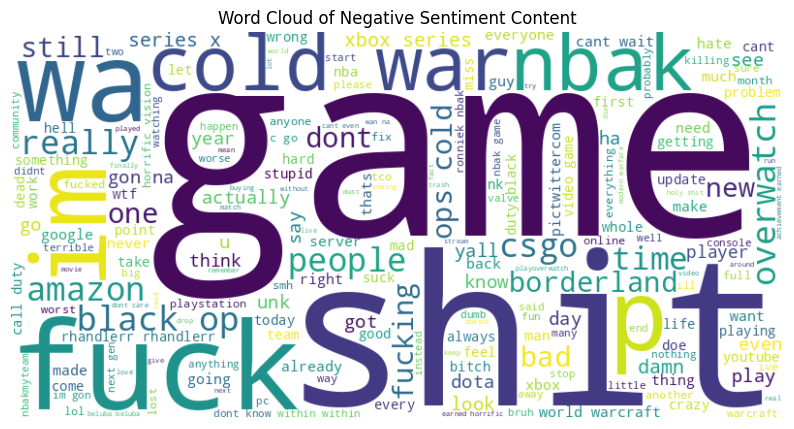

In [ ]:
# Filter data for negative sentiment
negative_data = df[df['Sentiment_Predicted'] == 'Negative']
# Combine all lemmatized text for negative sentiment
negative_text_data = ' '.join(negative_data['Cleaned_Content'].dropna())
# Generate a word cloud for negative sentiment
negative_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(negative_text_data)
# Display the word cloud for negative sentiment
plt.figure(figsize=(10, 6))
plt.imshow(negative_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud of Negative Sentiment Content")
plt.show()

##Word Cloud for Neutral Sentiment

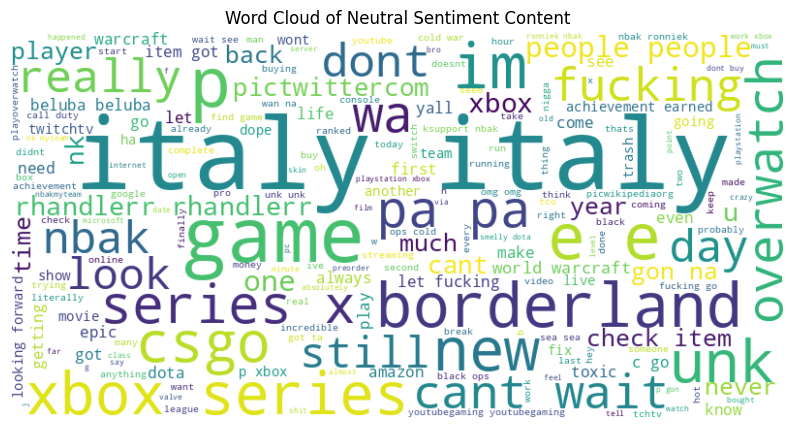

In [ ]:
# Filter data for neutral sentiment
neutral_data = df[df['Sentiment_Predicted'] == 'Neutral']
# Combine all lemmatized text for neutral sentiment
neutral_text_data = ' '.join(neutral_data['Cleaned_Content'].dropna())
# Generate a word cloud for neutral sentiment
neutral_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(neutral_text_data)
# Display the word cloud for neutral sentiment
plt.figure(figsize=(10, 6))
plt.imshow(neutral_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud of Neutral Sentiment Content")
plt.show()

##Data Splitting

In [ ]:
# Assign the variables
X = df['Cleaned_Content']  # Features
y = df['Sentiment_Predicted']  # Target
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

##Feature Extraction (Vectorization)

In [ ]:
tfidf_vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1, 2))
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

##Model Training

In [ ]:
# Initialize the model
model = LogisticRegression(max_iter=1000, solver='saga')
model.fit(X_train_tfidf, y_train)

LogisticRegression(max_iter=1000, solver='saga')

In [ ]:
# Predict on the test set
y_pred = model.predict(X_test_tfidf)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.8986928104575164
              precision    recall  f1-score   support

    Negative       0.89      0.88      0.88      1441
     Neutral       0.89      0.80      0.84       787
    Positive       0.91      0.95      0.93      2362

    accuracy                           0.90      4590
   macro avg       0.90      0.87      0.88      4590
weighted avg       0.90      0.90      0.90      4590



##Observation

The sentiment analysis model showcased remarkable performance across three sentiment categories: Negative, Neutral, and Positive. Here's a concise overview of its performance:

Accuracy: The model achieved an overall accuracy of approximately 90.68%, demonstrating its effectiveness in correctly classifying sentiments. Precision: Precision measures the accuracy of positive predictions. The model exhibited precision rates of 90% for Negative, 89% for Neutral, and an impressive 92% for Positive sentiments.

Recall (Sensitivity): Recall assesses the model's ability to identify actual positive instances. It achieved recall rates of 90% for Negative, 85% for Neutral, and a strong 93% for Positive sentiments.

F1-Score: The F1-score, which balances precision and recall, ranged from 87% to 93% across sentiment categories.

Macro and Weighted Averages : Both macro and weighted averages were around 90% and 91%, respectively, indicating consistent performance across classes and considering class imbalance

The classification report reveals that the model performs admirably in classifying sentiments across Negative, Neutral, and Positive categories. It demonstrates a balance between precision and recall, with F1-scores ranging from 87% to 93%. Additionally, the high accuracy of 90.68% suggests that the model excels in making correct predictions across sentiment

Sentiment Diversity: The project revealed a diverse range of sentiment expressions, including positive, negative, and neutral sentiments. This diversity underscores the importance of understanding the nuanced attitudes of social media users.

Positive Sentiment Dominance: Positive sentiments were the most prevalent, followed by negative sentiments and neutral sentiments. This suggests that, overall, the audience had a positive outlook, but there were still areas of concern.

Entity-specific Insights: Analyzing sentiment by entities (brands, topics, etc.) provided granular insights. Some entities received consistently positive sentiment, while others faced challenges with negative sentiment. This information helps in targeted brand management. Text Length Analysis: The distribution of text lengths revealed variations in the amount of content posted. Understanding these variations can aid in content planning and engagement strategies.

Word Frequency Analysis: Identifying the most common words in the text data highlighted the key topics and themes discussed on social media. Brands can leverage this information for content creation and engagement.

Word Cloud Analysis: Word clouds showcased prominent terms associated with positive, negative, and neutral sentiments. This visual representation aids in quickly identifying focus areas for sentiment improvement or celebration.

Machine Learning Model: The Logistic Regression model achieved an accuracy of approximately 90.68% in sentiment classification. It provides a reliable tool for automating sentiment analysis tasks MaddenNFL: This entity experiences the highest negative sentiment, indicating a notable amount of negativity in conversations related to Madden NFL.

TomClancyRainbowSix: Tom Clancy's Rainbow Six also faces a significant negative sentiment, warranting attention to address specific concerns.

Verizon: In contrast, Verizon maintains the highest neutral sentiment, suggesting a balanced sentiment distribution in conversations